In [594]:
import pandas as pd
import numpy as np
import matplotlib as plt

In [595]:
df = pd.read_csv(r'C:\Users\james\AppData\Local\Temp\Temp1_199387_1319582_bundle_archive.zip\US_Accidents_June20.csv')

#Smaller sample
df = df.sample(n=100000, random_state=42)

#Putting Times in datetime format
df['Start_Time']= pd.to_datetime(df['Start_Time'])
df['End_Time']= pd.to_datetime(df['End_Time'])
df['year'] = df['Start_Time'].dt.year
df['month'] = df['Start_Time'].dt.month
df['day'] = df['Start_Time'].dt.day
df['hour'] = df['Start_Time'].dt.hour
df['Weekday']=df['Start_Time'].dt.strftime('%a')

df['traffic_disruption(min)'] = round((df['End_Time'] - df['Start_Time'])/np.timedelta64(1,'m'))
df.drop(['Start_Time', 'End_Time'], axis=1, inplace=True)

td = 'traffic_disruption(min)'

In [596]:
unique_cats = df.select_dtypes('object').nunique()
unique_cats

ID                       100000
Source                        3
Description               87545
Street                    28209
Side                          2
City                       5743
County                     1169
State                        48
Zipcode                   33202
Country                       1
Timezone                      4
Airport_Code               1531
Weather_Timestamp         72356
Wind_Direction               24
Weather_Condition            77
Sunrise_Sunset                2
Civil_Twilight                2
Nautical_Twilight             2
Astronomical_Twilight         2
Weekday                       7
dtype: int64

In [597]:
#High cardinality categories
high_card = [col for col in unique_cats.index if unique_cats[col]>127]
high_card

['ID',
 'Description',
 'Street',
 'City',
 'County',
 'Zipcode',
 'Airport_Code',
 'Weather_Timestamp']

In [598]:
def wrangle(X):
    X = X.copy()
    #Drop high cardinality columns
    X.drop(high_card, axis=1, inplace=True)
    
    #Drop more columns- country and turning loop only have 1 unique value
    X.drop(['Turning_Loop', 'Country'], axis=1, inplace=True)
    
    #Set negative time values to NaN
    X[X[td]<=0] = np.nan
    
    return X

In [599]:
df = wrangle(df)

In [600]:
df.head()

,Source,TMC,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Number,Side,...,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,year,month,day,hour,Weekday,traffic_disruption(min)
3173614,Bing,NaN,2.0,40.847160,-73.933490,40.850020,-73.943990,0.583,NaN,R,...,Night,Day,Day,Day,2019.0,3.0,1.0,6.0,Fri,29.0
2560694,Bing,NaN,3.0,39.290699,-84.443617,39.290464,-84.442706,0.051,NaN,R,...,Day,Day,Day,Day,2016.0,8.0,30.0,18.0,Tue,360.0
708186,MapQuest,201.0,2.0,33.483852,-82.083969,NaN,NaN,0.000,NaN,R,...,Night,Night,Night,Night,2020.0,2.0,11.0,4.0,Tue,185.0
2231588,MapQuest,241.0,2.0,36.560585,-79.882690,NaN,NaN,0.000,9980.0,L,...,Day,Day,Day,Day,2017.0,11.0,3.0,12.0,Fri,45.0
1755423,MapQuest,201.0,3.0,43.071461,-73.751770,NaN,NaN,0.000,NaN,R,...,Day,Day,Day,Day,2018.0,7.0,6.0,15.0,Fri,30.0


In [601]:
df.isnull().sum()

Source                         1
TMC                        29480
Severity                       1
Start_Lat                      1
Start_Lng                      1
End_Lat                    70521
End_Lng                    70521
Distance(mi)                   1
Number                     64504
Side                           1
State                          1
Timezone                     114
Temperature(F)              1885
Wind_Chill(F)              53170
Humidity(%)                 2010
Pressure(in)                1615
Visibility(mi)              2218
Wind_Direction              1711
Wind_Speed(mph)            12948
Precipitation(in)          57663
Weather_Condition           2207
Amenity                        1
Bump                           1
Crossing                       1
Give_Way                       1
Junction                       1
No_Exit                        1
Railway                        1
Roundabout                     1
Station                        1
Stop      

<AxesSubplot:ylabel='Frequency'>

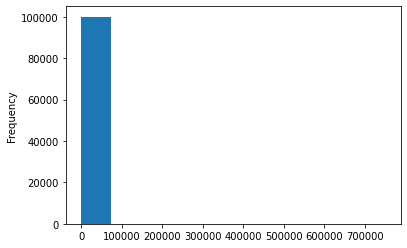

In [602]:
df['traffic_disruption(min)'].plot(kind='hist')

In [603]:
target = 'Severity'

y = df[target]
X = df.drop(target, axis=1)

In [604]:
y.value_counts(normalize=True)

2.0    0.675457
3.0    0.283663
4.0    0.032170
1.0    0.008710
Name: Severity, dtype: float64

In [605]:
#Baseline accuracy
baseline_acc = y.value_counts(normalize=True).max()
print('Baseline accuracy:',baseline_acc)

Baseline accuracy: 0.6754567545675457


In [606]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(df, test_size=.2, random_state=42)
X_train, y_train = train.drop(target, axis=1), train[target]
X_val, y_val = val.drop(target, axis=1), val[target]

In [607]:
print(train.shape, val.shape, df.shape)

(80000, 43) (20000, 43) (100000, 43)


#Logistic Regression

In [608]:
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from xgboost import XGBClassifier

In [609]:
model = make_pipeline(
        OrdinalEncoder(),
        SimpleImputer(strategy='median'),
        LogisticRegression(n_jobs=-1)
)
model.fit(X_train,y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
print("Training accuracy:", model.score(X_train,y_train))
print("Validation accuracy:", model.score(X_val,y_val))

# Decision Tree Model

In [ ]:
model_dt = make_pipeline(       
        OrdinalEncoder(),
        SimpleImputer(strategy='mean'),
        DecisionTreeClassifier()
)
model_dt.fit(X_train,y_train)

In [ ]:
print("Training accuracy:", model_dt.score(X_train,y_train))
print("Validation accuracy:", model_dt.score(X_val,y_val))

# Random Forest Model

In [ ]:
model_rf = make_pipeline(
        OrdinalEncoder(),
        SimpleImputer(strategy='mean'),
        RandomForestClassifier()
)
model_rf.fit(X_train, y_train)

In [ ]:
print("Training accuracy:", model_rf.score(X_train,y_train))
print("Validation accuracy:", model_rf.score(X_val,y_val))

# XGBClassifier Model

In [ ]:
model_xgb = make_pipeline(
        OrdinalEncoder(),
        SimpleImputer(strategy='mean'),
        XGBClassifier()
)
model_xgb.fit(X_train,y_train)

In [ ]:
print("Training accuracy:", model_xgb.score(X_train,y_train))
print("Validation accuracy:", model_xgb.score(X_val,y_val))

# Tune Model

# Drop-Column Importance

In [ ]:
#feature_imp = model.named_steps['logisticregression'].feature_importances_
#features= X_train.columns

In [ ]:
pd.series(feature_imp, features).sort_values(ascending=False).head(5).plot(kind='barh')